In [1]:
import pandas as pd
import numpy as np

from plotnine import *
from plotnine.data import *

%matplotlib inline

### Density Plot

In [2]:
mpg.head()

,manufacturer,model,displ,year,cyl,trans,drv,cty,hwy,fl,class
0,audi,a4,1.8,1999,4,auto(l5),f,18,29,p,compact
1,audi,a4,1.8,1999,4,manual(m5),f,21,29,p,compact
2,audi,a4,2.0,2008,4,manual(m6),f,20,31,p,compact
3,audi,a4,2.0,2008,4,auto(av),f,21,30,p,compact
4,audi,a4,2.8,1999,6,auto(l5),f,16,26,p,compact


The defaults are not exactly beautiful, but still quite clear.

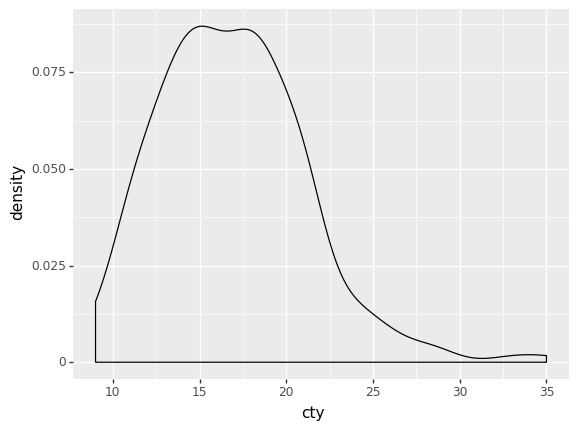

<ggplot: (97654321012345679)>

In [3]:
(
    ggplot(mpg, aes(x='cty'))
    + geom_density()
)

Plotting multiple groups is straightforward, but as each group is plotted as an independent PDF summing to 1, the relative size of each group will be normalized.

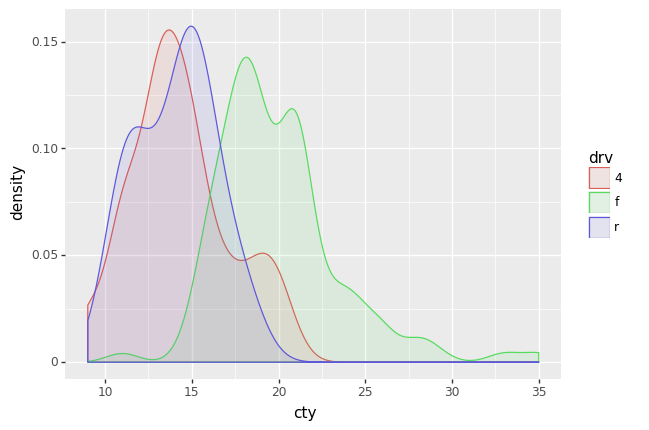

<ggplot: (97654321012345679)>

In [4]:
(
    ggplot(mpg, aes(x='cty', color='drv', fill='drv'))
    + geom_density(alpha=0.1)
)

To plot multiple groups and scale them by their relative size, you can pass `stat(count)` to the mapping.

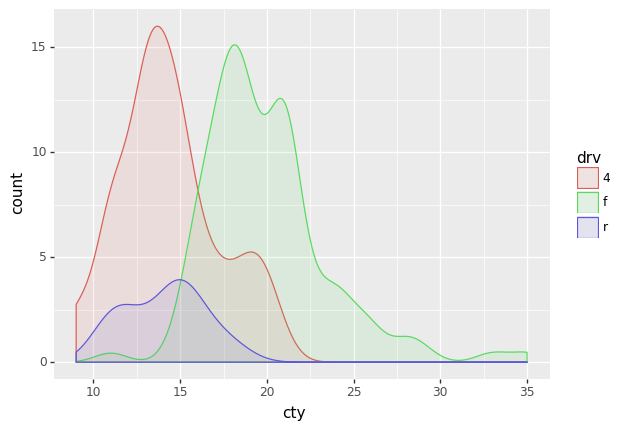

<ggplot: (97654321012345679)>

In [5]:
(
    ggplot(mpg, aes(x='cty', color='drv', fill='drv'))
    + geom_density(
        aes(y='stat(count)'),
        alpha=0.1
    )
)